In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [2]:
RANDOM_SEED = 20210102

In [3]:
train_df = pd.read_csv('data/train.csv')
submission_df = pd.read_csv('data/test.csv')

# Dataset Overview

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [6]:
train_image_df = train_df.copy()
train_image_df.drop(columns=['label'], inplace=True)

train_label_df = train_df['label']

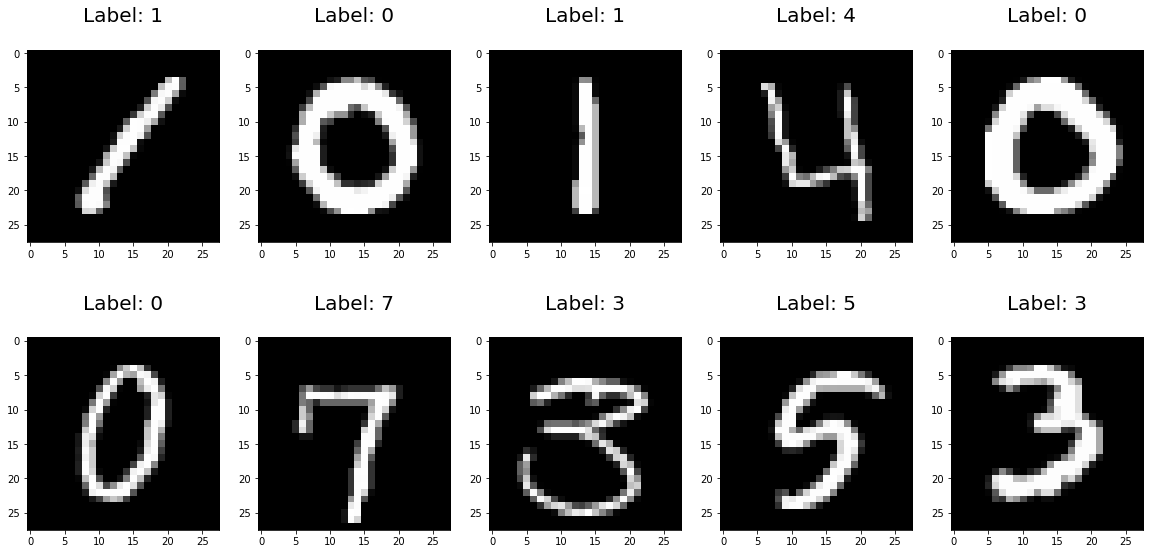

In [7]:
plt.figure(figsize=(20, 15))

for index, (image, label) in enumerate(zip(train_image_df[0:10], train_label_df[0:10])):
    plt.subplot(3, 5, index + 1)
    plt.imshow(np.reshape(train_image_df.values[index], (28, 28)), cmap='gray')

    plt.title('Label: %i\n' % label, fontsize=20);

## Digit Pixel Distribution

In [8]:
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


Digit pictures consists of **28x28=784** pixels, each pixel can take value from 0 to 255 range (gray-scale).

We can immediately recognize that **some of the pixels always contain zero value** accross all samples (pixel0, pixel1, pixel2, pixel3, pixel4, etc).

## Label Distribution

<AxesSubplot:xlabel='label', ylabel='Count'>

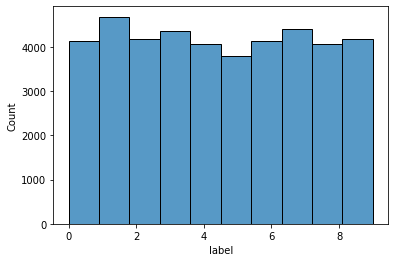

In [9]:
sns.histplot(x=train_label_df, bins=10)

In [10]:
train_label_df.value_counts(), train_label_df.value_counts(normalize=True)

(1    4684
 7    4401
 3    4351
 9    4188
 2    4177
 6    4137
 0    4132
 4    4072
 8    4063
 5    3795
 Name: label, dtype: int64,
 1    0.111524
 7    0.104786
 3    0.103595
 9    0.099714
 2    0.099452
 6    0.098500
 0    0.098381
 4    0.096952
 8    0.096738
 5    0.090357
 Name: label, dtype: float64)

## Test Dataset

In [11]:
train_image_df = train_image_df.astype('float32') / 255.0
submission_df = submission_df.astype('float32') / 255.0

In [12]:
validation_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
test_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=RANDOM_SEED)

for train_idx, val_idx in validation_splitter.split(train_image_df, train_label_df):
    X_train, y_train = train_image_df.iloc[train_idx], train_label_df.iloc[train_idx]
    X_val, y_val = train_image_df.iloc[val_idx], train_label_df.iloc[val_idx]

for train_idx, test_idx in test_splitter.split(X_train, y_train):
    X_test, y_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
    X_train, y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]

<AxesSubplot:xlabel='label', ylabel='Count'>

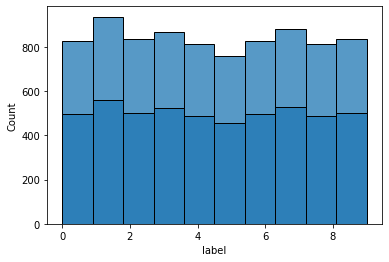

In [13]:
sns.histplot(data=y_val, bins=10)
sns.histplot(data=y_test, bins=10)

# Classification 🧪

## Multilayer Perceptron

In [14]:
NUM_CLASSES = 10

y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

### Architecture

In [15]:
input_layer = Input((784))

x = Flatten()(input_layer)

x = Dense(200, activation='relu')(x)
x = Dense(150, activation='relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
Total params: 188,660
Trainable params: 188,660
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_train.shape

(28560, 10)

In [17]:
y_val.shape

(8400, 10)

### Training

In [18]:
optimizer = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

train_history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=32, 
    epochs=20, 
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/20
893/893 [==============================] - 2s 2ms/step - loss: 0.6240 - accuracy: 0.8265 - val_loss: 0.1850 - val_accuracy: 0.9470
Epoch 2/20
893/893 [==============================] - 1s 1ms/step - loss: 0.1510 - accuracy: 0.9540 - val_loss: 0.1553 - val_accuracy: 0.9529
Epoch 3/20
893/893 [==============================] - 1s 1ms/step - loss: 0.0956 - accuracy: 0.9709 - val_loss: 0.1130 - val_accuracy: 0.9644
Epoch 4/20
893/893 [==============================] - 1s 1ms/step - loss: 0.0703 - accuracy: 0.9793 - val_loss: 0.1046 - val_accuracy: 0.9693
Epoch 5/20
893/893 [==============================] - 1s 1ms/step - loss: 0.0479 - accuracy: 0.9855 - val_loss: 0.1199 - val_accuracy: 0.9639
Epoch 6/20
893/893 [==============================] - 1s 1ms/step - loss: 0.0356 - accuracy: 0.9889 - val_loss: 0.1197 - val_accuracy: 0.9656
Epoch 7/20
893/893 [==============================] - 1s 1ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.1007 - val_accuracy: 0.9724
Epoch 

Best Validation Loss: 0.1007
Best Validation Accuracy: 0.9755


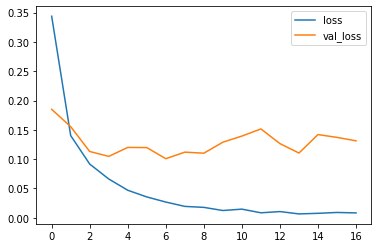

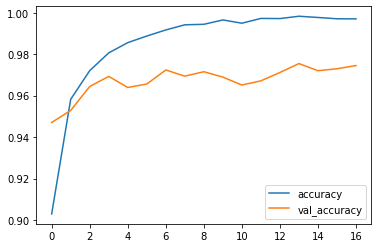

In [19]:
train_history_df = pd.DataFrame(train_history.history)

train_history_df[['loss', 'val_loss']].plot()
train_history_df[['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(train_history_df['val_loss'].min(), 
              train_history_df['val_accuracy'].max()))

### Evaluation

In [20]:
model.evaluate(X_test, y_test)

158/158 [==============================] - 0s 596us/step - loss: 0.1105 - accuracy: 0.9696


[0.11045512557029724, 0.9696428775787354]

In [29]:
y_submission = np.argmax(model.predict(submission_df), axis=-1)

submission_label_df = pd.DataFrame({
    'ImageId': list(range(1, len(y_submission) + 1)), 
    'Label': y_submission
})

submission_label_df.to_csv('data/mlp_submission.csv', index=False, header=True)